In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenews1/True.csv
/kaggle/input/fakenews1/Fake.csv


# Fake News Detection 
#### Deep Learning Project
#### Keerthana Saravanan (CS22B1019)
#
## MODELS:
#### BiLSTM
#### CNN+BiLSTM
#### Transformer based Fake News classifier
#### Finetuned DistilBERT (text + metadata)

# 1) Data Loading , Preprocessing ,EDA

In [21]:
import pandas as pd
import os

# Define the paths to the CSV files within the specified folder in Kaggle
true_file_path = os.path.join('../input/fakenews1', 'True.csv')
false_file_path = os.path.join('../input/fakenews1', 'Fake.csv')

# Load the first CSV file into a pandas DataFrame
try:
    true_df = pd.read_csv(true_file_path)
    print("True DataFrame ready ....")
except FileNotFoundError:
    print(f"Error: File not found at {true_file_path}")
except Exception as e:
    print(f"An error occurred while reading {true_file_path}: {e}")

# Load the second CSV file into a pandas DataFrame
try:
    false_df = pd.read_csv(false_file_path)
    print("\nFalse DataFrame ready ....")
except FileNotFoundError:
    print(f"Error: File not found at {false_file_path}")
except Exception as e:
    print(f"An error occurred while reading {false_file_path}: {e}")

True DataFrame ready ....

False DataFrame ready ....


In [22]:
true_df.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [23]:
false_df.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [24]:
true_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [25]:
false_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [26]:
# Get unique values and their counts for the 'subject' column in true_df
print("Unique values and counts in 'subject' column of True DataFrame:")
print(true_df['subject'].value_counts())

# Get unique values and their counts for the 'subject' column in false_df
print("\nUnique values and counts in 'subject' column of False DataFrame:")
print(false_df['subject'].value_counts())

Unique values and counts in 'subject' column of True DataFrame:
subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

Unique values and counts in 'subject' column of False DataFrame:
subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64


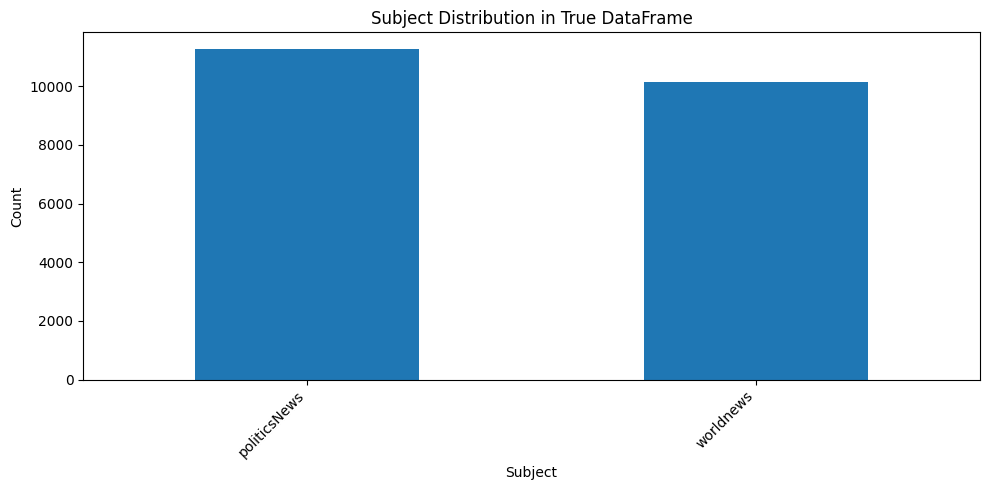

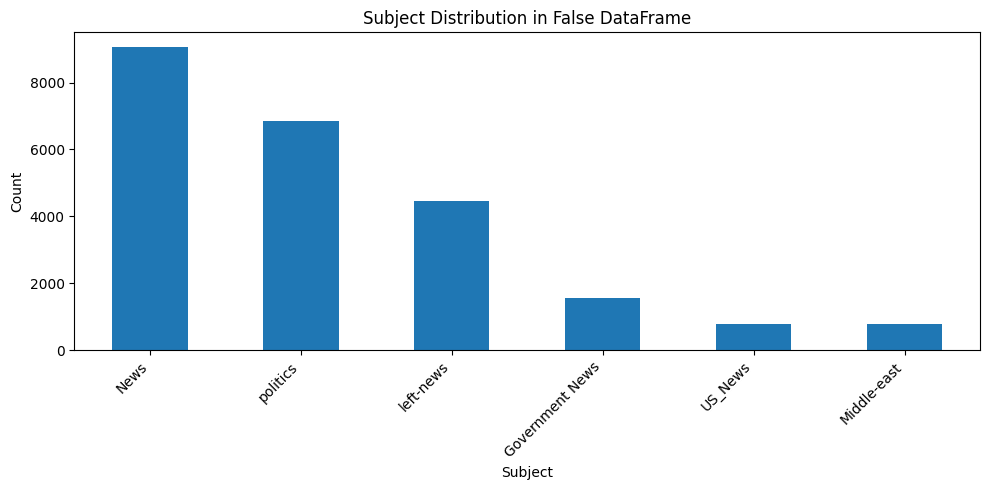

In [27]:
import matplotlib.pyplot as plt

# Plotting for true_df
plt.figure(figsize=(10, 5))  # Adjust figure size for better readability
true_df['subject'].value_counts().plot(kind='bar')
plt.title('Subject Distribution in True DataFrame')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Plotting for false_df
plt.figure(figsize=(10, 5))
false_df['subject'].value_counts().plot(kind='bar')
plt.title('Subject Distribution in False DataFrame')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

def transform_date(df):
    day_list = []
    month_list = []
    year_list = []
    unparsed_indices = []

    for index, date_str in df['date'].items():
        try:
            # Remove the ' - ' part if present and then try to parse
            date_part = date_str.split(' - ')[-1].strip()
            parsed_date = pd.to_datetime(date_part)
            day_list.append(parsed_date.day)
            month_list.append(parsed_date.month)
            year_list.append(parsed_date.year)
        except ValueError:
            unparsed_indices.append(index)
            day_list.append(None)
            month_list.append(None)
            year_list.append(None)
        except Exception as e:
            print(f"An unexpected error occurred while processing index {index}: {e}")
            unparsed_indices.append(index)
            day_list.append(None)
            month_list.append(None)
            year_list.append(None)

    df['day'] = day_list
    df['month'] = month_list
    df['year'] = year_list
    df = df.drop(columns=['date'])
    return df, unparsed_indices

# Apply the transformation to both DataFrames
true_df, true_unparsed_indices = transform_date(true_df.copy())
fake_df, false_unparsed_indices = transform_date(false_df.copy())

# Print the heads of the transformed DataFrames
print("Transformed True DataFrame ready ...")
# print(true_df.head())
print("\nTransformed Fake DataFrame ready ...")
# print(fake_df.head())

# Print the indices of the unparsed dates and their counts
print(f"\nNumber of unparsed dates in True DataFrame: {len(true_unparsed_indices)}")
if true_unparsed_indices:
    print(f"Indices of unparsed dates in True DataFrame: {true_unparsed_indices[:10]}...") # Print first 10 for brevity

print(f"\nNumber of unparsed dates in False DataFrame: {len(false_unparsed_indices)}")
if false_unparsed_indices:
    print(f"Indices of unparsed dates in False DataFrame: {false_unparsed_indices[:10]}...") # Print first 10 for brevity

Transformed True DataFrame ready ...

Transformed Fake DataFrame ready ...

Number of unparsed dates in True DataFrame: 0

Number of unparsed dates in False DataFrame: 10
Indices of unparsed dates in False DataFrame: [9358, 15507, 15508, 15839, 15840, 17432, 17433, 18933, 21869, 21870]...


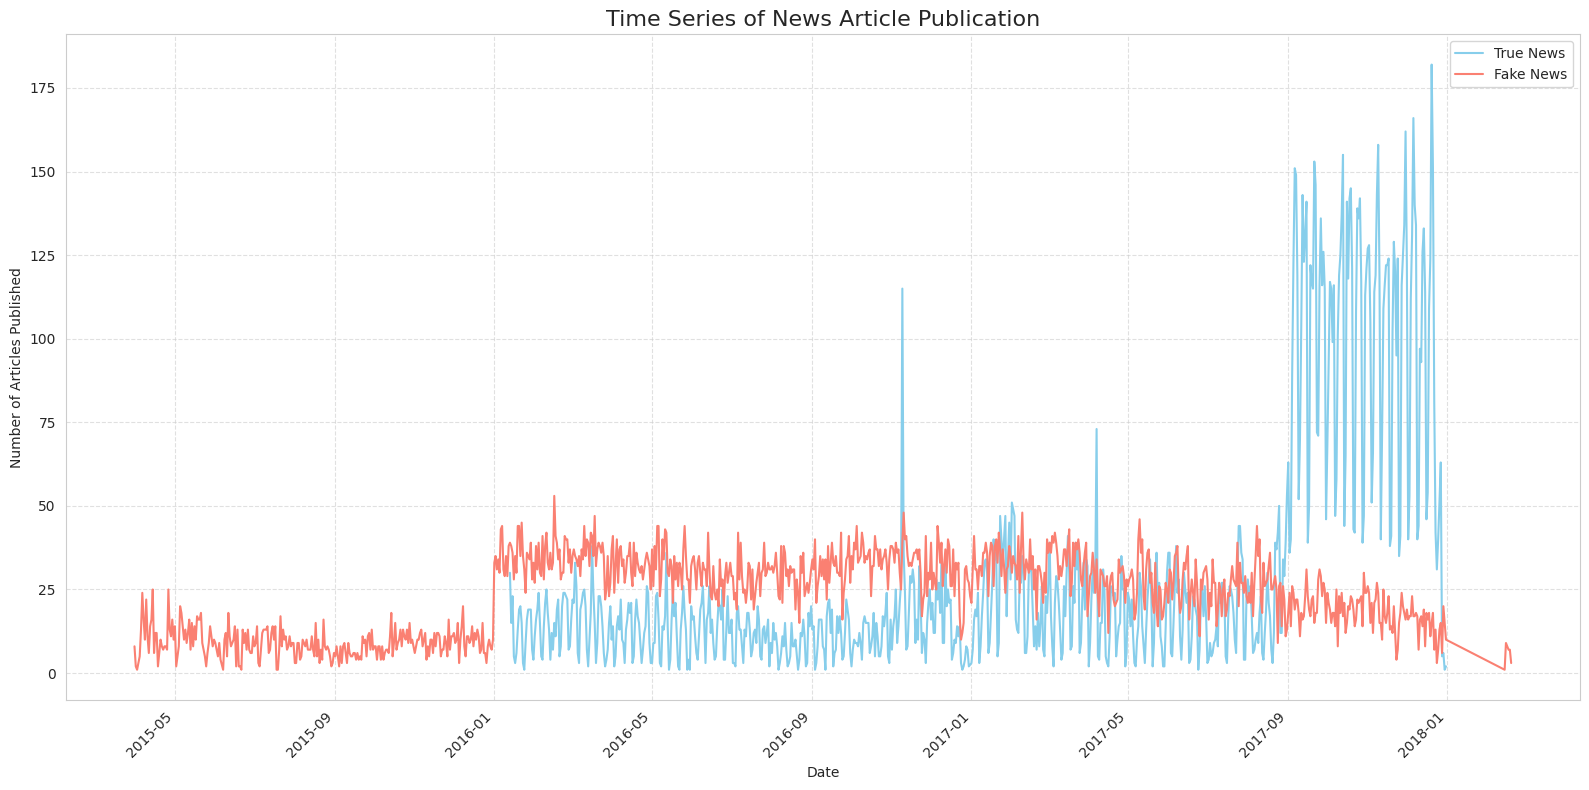

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your true and fake news data are in pandas DataFrames called
# 'true_df' and 'fake_df', and they have 'day', 'month', and 'year' columns.

# Function to create a datetime object from day, month, year
def create_datetime(row):
    try:
        return pd.to_datetime(f"{int(row['year'])}-{int(row['month']):02d}-{int(row['day']):02d}")
    except ValueError:
        return None  # Handle potential invalid date combinations

# Create 'date' column for True News
if 'day' in true_df.columns and 'month' in true_df.columns and 'year' in true_df.columns:
    true_df['date'] = true_df.apply(create_datetime, axis=1)
    true_df.dropna(subset=['date'], inplace=True)  # Remove rows with invalid dates
else:
    print("Warning: Missing 'day', 'month', or 'year' column in true_df.")

# Create 'date' column for Fake News
if 'day' in fake_df.columns and 'month' in fake_df.columns and 'year' in fake_df.columns:
    fake_df['date'] = fake_df.apply(create_datetime, axis=1)
    fake_df.dropna(subset=['date'], inplace=True)  # Remove rows with invalid dates
else:
    print("Warning: Missing 'day', 'month', or 'year' column in fake_df.")

# Set a visually appealing style
sns.set_style("whitegrid")

# Aggregate counts by date for True News
if 'date' in true_df.columns:
    true_date_counts = true_df['date'].value_counts().sort_index()
else:
    true_date_counts = pd.Series()
    print("Error: 'date' column could not be created for true_df. Cannot plot.")

# Aggregate counts by date for Fake News
if 'date' in fake_df.columns:
    fake_date_counts = fake_df['date'].value_counts().sort_index()
else:
    fake_date_counts = pd.Series()
    print("Error: 'date' column could not be created for fake_df. Cannot plot.")

# Create the time series line graph
if not true_date_counts.empty or not fake_date_counts.empty:
    plt.figure(figsize=(16, 8))  # Adjust figure size for better readability
    plt.title('Time Series of News Article Publication', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Number of Articles Published')
    plt.grid(True, which='major', linestyle='--', alpha=0.6)

    if not true_date_counts.empty:
        plt.plot(true_date_counts.index, true_date_counts.values, label='True News', color='skyblue', linestyle='-')

    if not fake_date_counts.empty:
        plt.plot(fake_date_counts.index, fake_date_counts.values, label='Fake News', color='salmon', linestyle='-')

    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Could not create the time series plot due to missing or invalid date information.")

In [33]:
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm  # Import tqdm for notebooks
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your true and fake news DataFrames ('true_df', 'fake_df')
# have 'day', 'month', and 'year' columns.

tqdm.pandas(desc="Processing DataFrame") # Initialize tqdm for pandas

def create_datetime(row):
    try:
        return pd.to_datetime(f"{int(row['year'])}-{int(row['month']):02d}-{int(row['day']):02d}")
    except ValueError:
        return None

# Create 'date' column if it doesn't exist
if 'date' not in true_df.columns and 'day' in true_df.columns and 'month' in true_df.columns and 'year' in true_df.columns:
    true_df['date'] = true_df.progress_apply(create_datetime, axis=1)
    true_df.dropna(subset=['date'], inplace=True)
elif 'date' not in true_df.columns:
    print("Warning: Could not create 'date' column in true_df. Ensure 'day', 'month', 'year' exist.")

if 'date' not in fake_df.columns and 'day' in fake_df.columns and 'month' in fake_df.columns and 'year' in fake_df.columns:
    fake_df['date'] = fake_df.progress_apply(create_datetime, axis=1)
    fake_df.dropna(subset=['date'], inplace=True)
elif 'date' not in fake_df.columns:
    print("Warning: Could not create 'date' column in fake_df. Ensure 'day', 'month', 'year' exist.")

# Assuming you have a reference date for calculating the age of the news.
reference_date = datetime(2025, 5, 7)

# Feature Engineering for True News
if 'date' in true_df.columns:
    true_df['age_of_news'] = (reference_date - true_df['date']).dt.days
    true_df['weekday'] = true_df['date'].dt.dayofweek  # Monday=0, Sunday=6
    true_df['month'] = true_df['date'].dt.month
    true_df['year'] = true_df['date'].dt.year
else:
    print("Warning: 'date' column missing in true_df. Cannot create time-based features.")

# Feature Engineering for Fake News
if 'date' in fake_df.columns:
    fake_df['age_of_news'] = (reference_date - fake_df['date']).dt.days
    fake_df['weekday'] = fake_df['date'].dt.dayofweek  # Monday=0, Sunday=6
    fake_df['month'] = fake_df['date'].dt.month
    fake_df['year'] = fake_df['date'].dt.year
else:
    print("Warning: 'date' column missing in fake_df. Cannot create time-based features.")

# Add 'is_alone_in_timeline' feature for Fake News
if 'date' in true_df.columns and 'date' in fake_df.columns:
    tqdm.pandas(desc="Calculating 'is_alone_in_timeline'")
    fake_df['is_alone_in_timeline'] = fake_df['date'].progress_apply(
        lambda date: 1 if not any(true_df['date'].dt.date == date.date()) else 0
    )
else:
    print("Warning: 'date' column missing in one or both DataFrames. Cannot create 'is_alone_in_timeline' feature.")

# Display the first few rows with the new features
print("True News DataFrame with new features:")
print(true_df.head())
print("\nFake News DataFrame with new features:")
print(fake_df.head())

# Stratified sampling (example)
if 'text' in true_df.columns and 'label' in true_df.columns and 'text' in fake_df.columns and 'label' in fake_df.columns:
    print("\nPerforming stratified train/validation split:")
    true_train_texts, true_val_texts, true_train_labels, true_val_labels = train_test_split(
        true_df['text'], true_df['label'], test_size=0.2, random_state=42, stratify=true_df['label']
    )
    print(f"  - True train split: {len(true_train_texts)} samples")
    print(f"  - True validation split: {len(true_val_texts)} samples")

    fake_train_texts, fake_val_texts, fake_train_labels, fake_val_labels = train_test_split(
        fake_df['text'], fake_df['label'], test_size=0.2, random_state=42, stratify=fake_df['label']
    )
    print(f"  - Fake train split: {len(fake_train_texts)} samples")
    print(f"  - Fake validation split: {len(fake_val_texts)} samples")

    # Combine and proceed with tokenization and model training
    train_texts = pd.concat([true_train_texts, fake_train_texts]).reset_index(drop=True)
    train_labels = pd.concat([true_train_labels, fake_train_labels]).reset_index(drop=True)
    val_texts = pd.concat([true_val_texts, fake_val_texts]).reset_index(drop=True)
    val_labels = pd.concat([true_val_labels, fake_val_labels]).reset_index(drop=True)

    print(f"\nCombined training set size: {len(train_texts)}")
    print(f"Combined validation set size: {len(val_texts)}")

else:
    print("\nWarning: 'text' or 'label' columns missing for stratified split example.")

Calculating 'is_alone_in_timeline':   0%|          | 0/23471 [00:00<?, ?it/s]

True News DataFrame with new features:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  day  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   31   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   29   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   31   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   30   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   29   

   month  year       date  age_of_news  weekday  
0     12  2017 2017-12-31         2684        6  
1     12  2017 2017-12-29         2686        4  
2     12  2017 2017-12-

In [29]:
true_df.head(2)

,title,text,subject,day,month,year
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31,12,2017
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29,12,2017


In [12]:
fake_df.head(2)

,title,text,subject,day,month,year
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31.0,12.0,2017.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31.0,12.0,2017.0


In [13]:
len(false_unparsed_indices)

10

In [14]:
# Indices of unparsed dates in False DataFrame (from your previous output)
# unparsed_false_indices = [9358, 15507, 15508, 15839, 15840, 17432, 17433, 18933, 21869, 21870]

# Print the 'date' column for these indices in false_df
print("Date column values for unparsed indices in False DataFrame:")
for index in false_unparsed_indices:
    if index in false_df.index:
        print(f"Index {index}: {false_df.loc[index, 'date']}")
    else:
        print(f"Index {index}: Index not found in DataFrame")

Date column values for unparsed indices in False DataFrame:
Index 9358: https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
Index 15507: https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
Index 15508: https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
Index 15839: https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Index 15840: https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
Index 17432: https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Index 17433: https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
Index 18933: MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
Index 21869: https://fedup.wpengine.com/wp-cont

In [15]:
# Indices of unparsed dates in False DataFrame
false_unparsed_indices = [9358, 15507, 15508, 15839, 15840, 17432, 17433, 18933, 21869, 21870]

# Create a new DataFrame containing only the rows with the unparsed indices
unparsed_false_df = false_df.loc[false_unparsed_indices]

# Print the new DataFrame
print("DataFrame of unparsed dates from False DataFrame:")
# print(unparsed_false_df)

DataFrame of unparsed dates from False DataFrame:


In [16]:
unparsed_false_df['date']

9358     https://100percentfedup.com/served-roy-moore-v...
15507    https://100percentfedup.com/video-hillary-aske...
15508    https://100percentfedup.com/12-yr-old-black-co...
15839    https://fedup.wpengine.com/wp-content/uploads/...
15840    https://fedup.wpengine.com/wp-content/uploads/...
17432    https://fedup.wpengine.com/wp-content/uploads/...
17433    https://fedup.wpengine.com/wp-content/uploads/...
18933    MSNBC HOST Rudely Assumes Steel Worker Would N...
21869    https://fedup.wpengine.com/wp-content/uploads/...
21870    https://fedup.wpengine.com/wp-content/uploads/...
Name: date, dtype: object

# 2) Bidirectional LSTM or BiLSTM


Training set size: 35918
Validation set size: 4490
Test set size: 4490
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9700 - loss: 0.1138 - val_accuracy: 0.9991 - val_loss: 0.0031
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.9996 - val_loss: 0.0031
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9991 - val_loss: 0.0033


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,263,269 (16.26 MB)

 Trainable params: 1,421,089 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,842,180 (10.84 MB)

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

===== Performance Metrics =====
           Training  Validation  Testing
Accuracy     0.9993      0.9991   0.9991
Precision    0.9994      0.9991   0.9991
Recall       0.9992      0.9991   0.9991
F1 Score     0.9993      0.9991   0.9991
AUC-ROC      0.9999      1.0000   0.9996


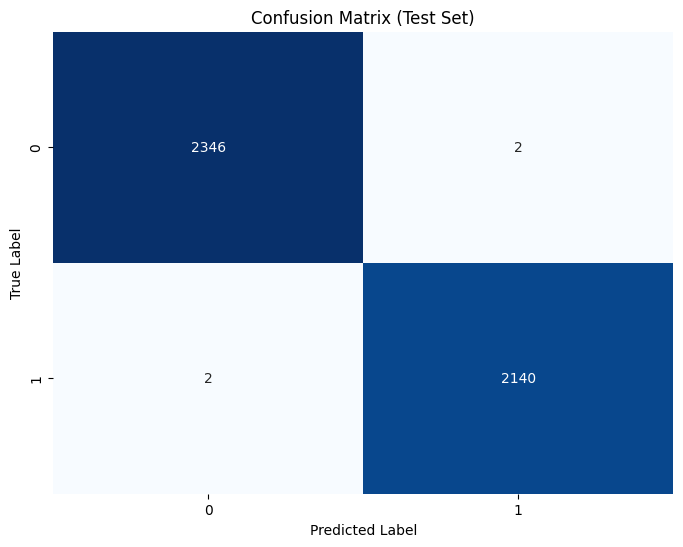

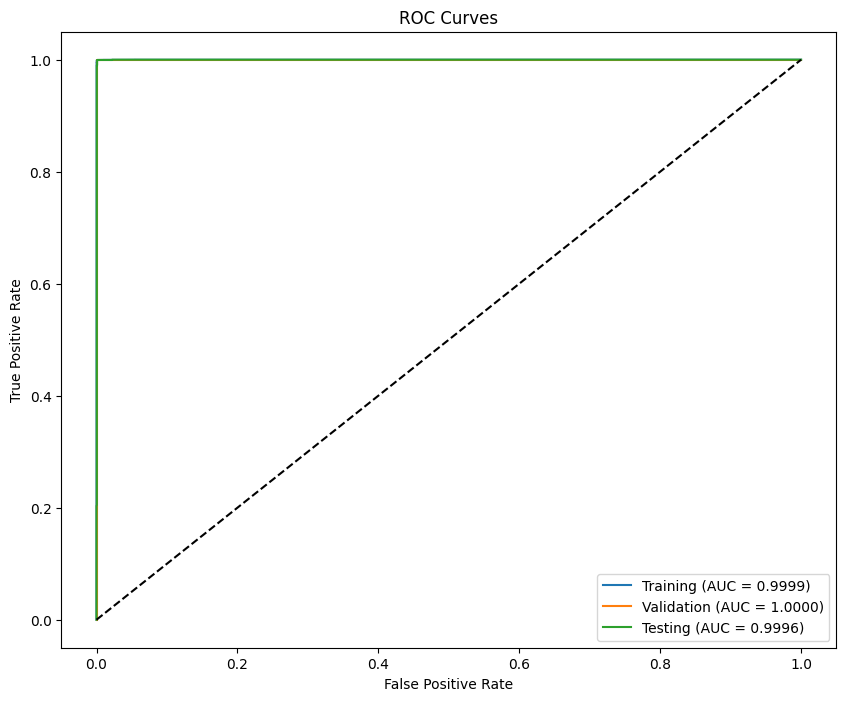

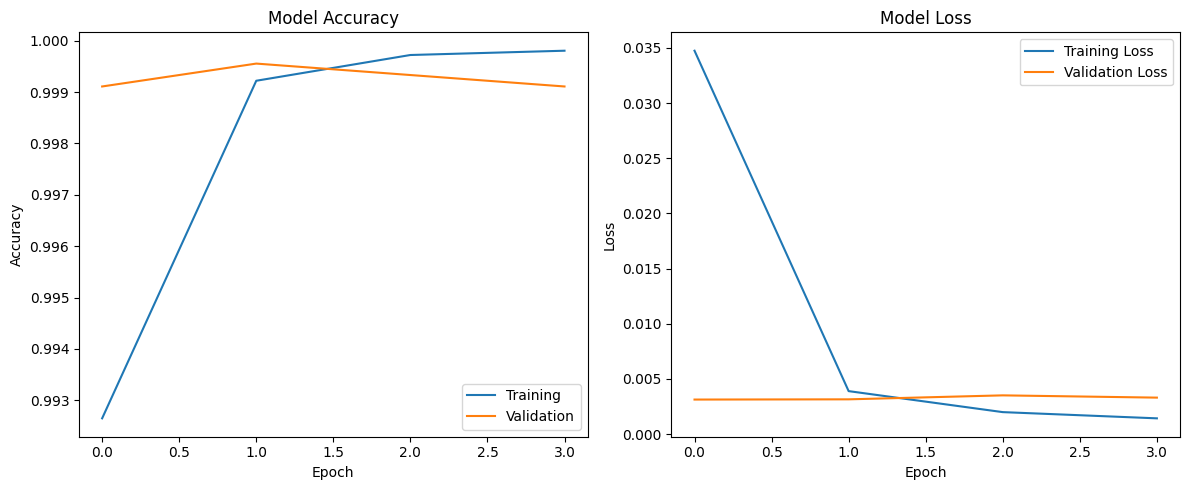


===== Classification Report (Test Set) =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2348
           1       1.00      1.00      1.00      2142

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490


===== Cohen's Kappa Scores =====
      Dataset  Cohen's Kappa
0    Training         0.9987
1  Validation         0.9982
2     Testing         0.9982

===== Training Summary =====
Number of epochs trained: 4
Best validation loss: 0.0031
Best validation accuracy: 0.9996

Model saved as 'fake_news_bilstm_model.h5'


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load the dataset
# Assuming true_df and fake_df are already loaded in Kaggle
# If not, you would load them like this:
# true_df = pd.read_csv('../input/isot_dataset/True.csv')
# fake_df = pd.read_csv('../input/isot_dataset/Fake.csv')

# Add a label column to each dataframe
true_df['label'] = 1  # 1 for true news
fake_df['label'] = 0  # 0 for fake news

# Combine both dataframes
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

# 2. Data Preprocessing
# Use the 'text' column for our model
df['text'] = df['text'].str.lower()  # Convert to lowercase

# 3. Split the data into training, validation, and test sets (80-10-10)
# First, split into 80% training and 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Then split the temp set into validation and test (50% each, which is 10% of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# 4. Tokenize the text
max_words = 10000  # Maximum number of words to keep
max_length = 200   # Max length of each news article (in words)

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# 5. Build the BiLSTM model
embedding_dim = 128  # Dimension of word embeddings

model = Sequential([
    # Embedding layer
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    
    # Dense output layer
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



# 6. Train the model
batch_size = 64
epochs = 10

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)
# Display model summary
model.summary()
# 7. Get predictions for all datasets
# Training set
y_train_pred_prob = model.predict(X_train_pad)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# Validation set
y_val_pred_prob = model.predict(X_val_pad)
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()

# Test set
y_test_pred_prob = model.predict(X_test_pad)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# 8. Calculate all metrics for all datasets
def calculate_metrics(y_true, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_prob)
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_pred_prob)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_prob)

# Create a DataFrame to display all metrics
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Testing': test_metrics
})

print("\n===== Performance Metrics =====")
print(metrics_df.round(4))

# Export metrics to CSV
metrics_df.to_csv('fake_news_detection_metrics.csv')

# 9. Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

# 10. Plot ROC Curves
from sklearn.metrics import roc_curve

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_true, y_pred_prob):.4f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_train, y_train_pred_prob, 'Training')
plot_roc_curve(y_val, y_val_pred_prob, 'Validation')
plot_roc_curve(y_test, y_test_pred_prob, 'Testing')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig('roc_curves.png')
plt.show()

# 11. Plot training history (loss and accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# 12. Classification Report
print("\n===== Classification Report (Test Set) =====")
print(classification_report(y_test, y_test_pred))

# Calculate Cohen's Kappa for all datasets
from sklearn.metrics import cohen_kappa_score

train_kappa = cohen_kappa_score(y_train, y_train_pred)
val_kappa = cohen_kappa_score(y_val, y_val_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

kappa_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Testing'],
    'Cohen\'s Kappa': [train_kappa, val_kappa, test_kappa]
})

print("\n===== Cohen's Kappa Scores =====")
print(kappa_df.round(4))

# Print final training information
print("\n===== Training Summary =====")
print(f"Number of epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

# Save the model
model.save('fake_news_bilstm_model.h5')
print("\nModel saved as 'fake_news_bilstm_model.h5'")

# 2) CNN , BiLSTM

Training set size: 35918
Validation set size: 4490
Test set size: 4490
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9259 - loss: 0.1465 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9975 - loss: 0.0117 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9993 - val_loss: 0.0027
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9998 - val_loss: 0.0020


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 200, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 200, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 50, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,485,029 (17.11 MB)

 Trainable params: 1,495,009 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,990,020 (11.41 MB)

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

===== Performance Metrics =====
               Training  Validation  Testing
Accuracy         0.9990      0.9998   0.9984
Precision        0.9988      0.9995   0.9977
Recall           0.9990      1.0000   0.9991
F1 Score         0.9989      0.9998   0.9984
AUC-ROC          1.0000      1.0000   0.9997
Cohen's Kappa    0.9979      0.9996   0.9969


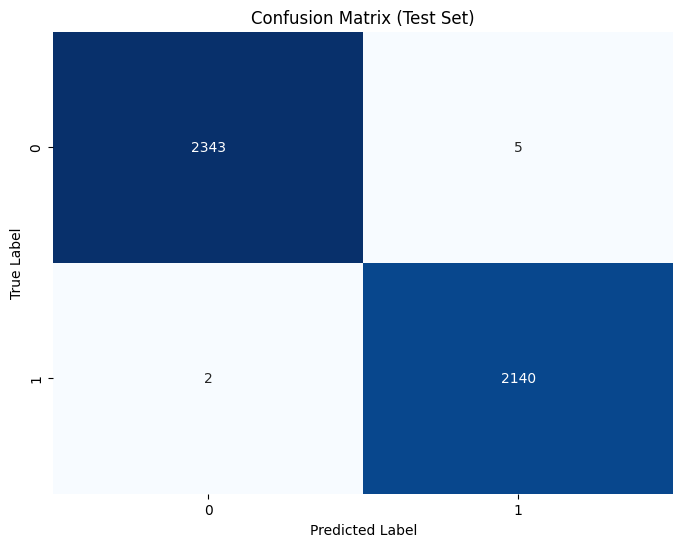

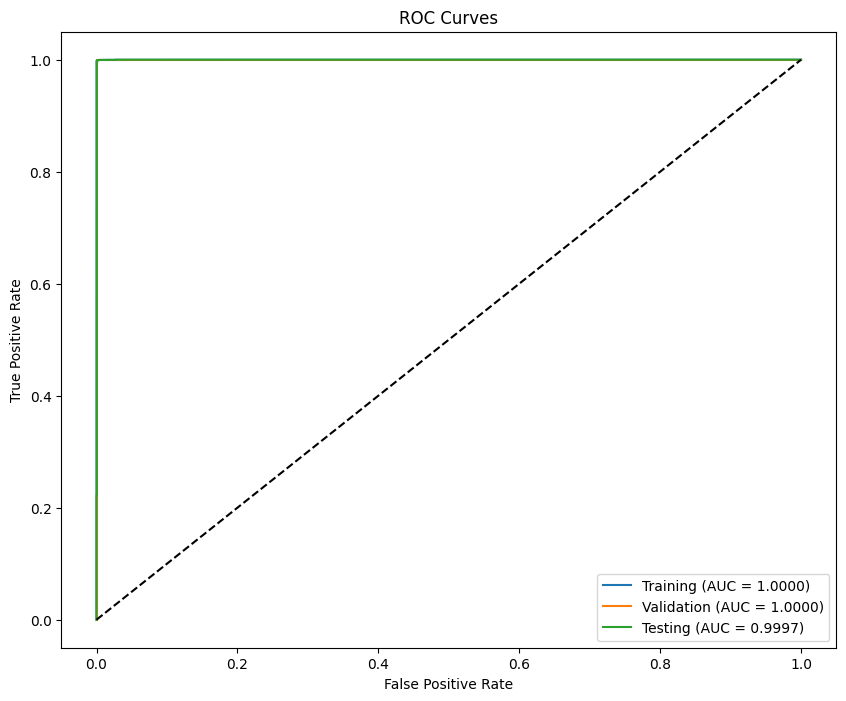

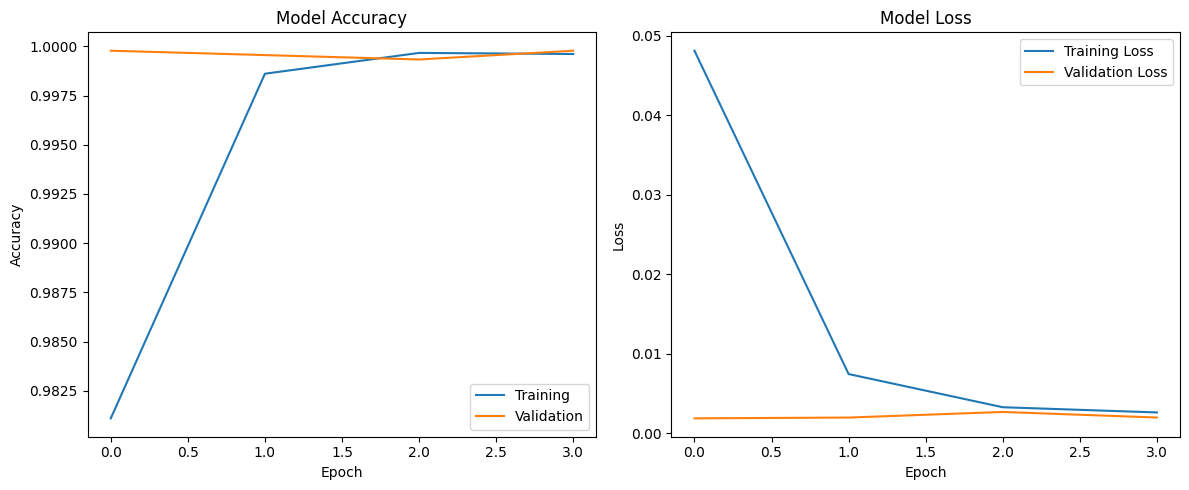


===== Classification Report (Test Set) =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2348
           1       1.00      1.00      1.00      2142

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490


===== Training Summary =====
Number of epochs trained: 4
Best validation loss: 0.0019
Best validation accuracy: 0.9998

Model saved as 'fake_news_cnn_bilstm_model.h5'


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load the dataset
# Assuming true_df and fake_df are already loaded in Kaggle
# If not, you would load them like this:
# true_df = pd.read_csv('../input/isot_dataset/True.csv')
# fake_df = pd.read_csv('../input/isot_dataset/Fake.csv')

# Add a label column to each dataframe
true_df['label'] = 1  # 1 for true news
fake_df['label'] = 0  # 0 for fake news

# Combine both dataframes
df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

# 2. Data Preprocessing
# Use the 'text' column for our model
df['text'] = df['text'].str.lower()  # Convert to lowercase

# 3. Split the data into training, validation, and test sets (80-10-10)
# First, split into 80% training and 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Then split the temp set into validation and test (50% each, which is 10% of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# 4. Tokenize the text
max_words = 10000  # Maximum number of words to keep
max_length = 200   # Max length of each news article (in words)

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# 5. Build the CNN-BiLSTM model
embedding_dim = 128  # Dimension of word embeddings

model = Sequential([
    # Embedding layer
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.2),  # Helps prevent overfitting in the embedding layer
    
    # CNN Layer Block
    Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # BiLSTM Layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    
    # Dense output layer
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



# 6. Train the model
batch_size = 64
epochs = 10

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)
# Display model summary
model.summary()
# 7. Get predictions for all datasets
# Training set
y_train_pred_prob = model.predict(X_train_pad)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# Validation set
y_val_pred_prob = model.predict(X_val_pad)
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()

# Test set
y_test_pred_prob = model.predict(X_test_pad)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# 8. Calculate all metrics for all datasets
def calculate_metrics(y_true, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'Cohen\'s Kappa': kappa
    }

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_prob)
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_pred_prob)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_prob)

# Create a DataFrame to display all metrics
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Testing': test_metrics
})

print("\n===== Performance Metrics =====")
print(metrics_df.round(4))

# Export metrics to CSV
metrics_df.to_csv('fake_news_cnn_bilstm_metrics.csv')

# 9. Confusion Matrix for Test Set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cnn_bilstm_confusion_matrix.png')
plt.show()

# 10. Plot ROC Curves
from sklearn.metrics import roc_curve

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_true, y_pred_prob):.4f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_train, y_train_pred_prob, 'Training')
plot_roc_curve(y_val, y_val_pred_prob, 'Validation')
plot_roc_curve(y_test, y_test_pred_prob, 'Testing')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig('cnn_bilstm_roc_curves.png')
plt.show()

# 11. Plot training history (loss and accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('cnn_bilstm_training_history.png')
plt.show()

# 12. Classification Report
print("\n===== Classification Report (Test Set) =====")
print(classification_report(y_test, y_test_pred))

# Print final training information
print("\n===== Training Summary =====")
print(f"Number of epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

# Save the model
model.save('fake_news_cnn_bilstm_model.h5')
print("\nModel saved as 'fake_news_cnn_bilstm_model.h5'")

# 4)Transformer Based Fake News Classifier

Training Transformer Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.0219 | Val Loss: 0.0014


Epoch 2/5:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.0040 | Val Loss: 0.0016


Epoch 3/5:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.0025 | Val Loss: 0.0000


Epoch 4/5:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0006 | Val Loss: 0.0000


Epoch 5/5:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.0012 | Val Loss: 0.0009


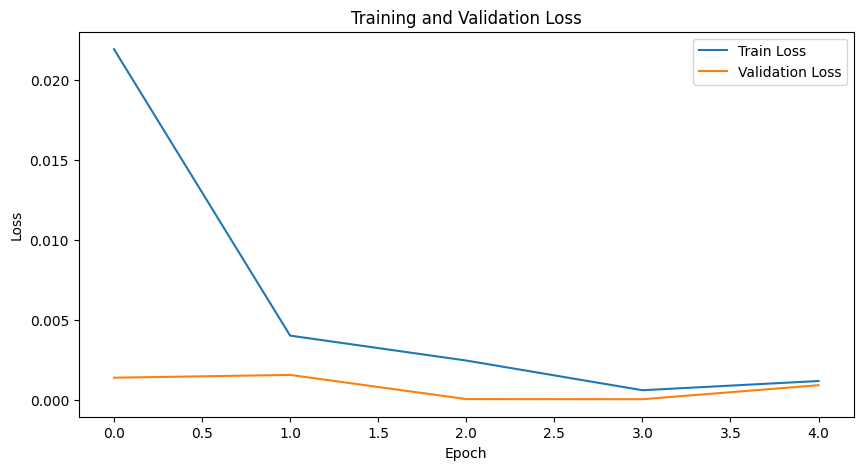


Final Metrics:
TRAIN  acc:0.9997 prec:0.9997 rec:0.9997 f1:0.9997 auc:0.9997 coe:0.9989 
VAL    acc:0.9997 prec:0.9994 rec:1.0000 f1:0.9997 auc:0.9997 coe:0.9989 
TEST   acc:0.9997 prec:1.0000 rec:0.9993 f1:0.9997 auc:0.9997 coe:0.9987 


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# 1. Data Preparation
def load_data():
    true_df = pd.read_csv('/kaggle/input/fakenews1/True.csv')
    fake_df = pd.read_csv('/kaggle/input/fakenews1/Fake.csv')
    
    true_df['label'] = 1
    fake_df['label'] = 0
    df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)
    df['text'] = df['title'] + " " + df['text']
    return df

df = load_data()

# 2. Dataset and Tokenization
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = [self.vocab.get(word, 1) for word in text.split()[:self.max_length]]  # 1 for UNK
        tokens = tokens + [0] * (self.max_length - len(tokens))  # 0 for PAD
        return torch.LongTensor(tokens), torch.LongTensor([self.labels[idx]])

# Build vocabulary
vocab = {'<PAD>': 0, '<UNK>': 1}
word_counts = defaultdict(int)
for text in df['text']:
    for word in text.split():
        word_counts[word] += 1
for idx, word in enumerate(word_counts, start=2):
    vocab[word] = idx

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

# Create datasets
train_dataset = NewsDataset(X_train.tolist(), y_train.tolist(), vocab)
val_dataset = NewsDataset(X_val.tolist(), y_val.tolist(), vocab)
test_dataset = NewsDataset(X_test.tolist(), y_test.tolist(), vocab)

# 3. Transformer Model Architecture
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward=256)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(embed_dim, 2)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, features)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Mean pooling
        return self.classifier(x)

# 4. Training Framework with COE
class Trainer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.metrics = defaultdict(dict)
    
    def coe(self, true, pred):
        """Coefficient of Efficiency (1 - MSE/var)"""
        mse = np.mean((np.array(true) - np.array(pred))**2)
        var = np.var(true)
        return max(0, 1 - mse/var) if var != 0 else 0
    
    def train(self, train_loader, val_loader, test_loader, epochs=5, lr=1e-3):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            self.model.train()
            epoch_train_loss = 0
            train_preds, train_labels = [], []
            
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                inputs, labels = inputs.to(self.device), labels.to(self.device).squeeze()
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
            
            # Store training loss
            avg_train_loss = epoch_train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)
            
            # Validation
            avg_val_loss, val_preds, val_labels = self._evaluate(val_loader, criterion)
            self.val_losses.append(avg_val_loss)
            
            # Calculate metrics
            self._calculate_metrics('train', train_labels, train_preds)
            self._calculate_metrics('val', val_labels, val_preds)
            
            # Test on final epoch
            if epoch == epochs - 1:
                _, test_preds, test_labels = self._evaluate(test_loader, criterion)
                self._calculate_metrics('test', test_labels, test_preds)
            
            print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        self._plot_losses()
        self._print_final_metrics()
    
    def _evaluate(self, loader, criterion):
        self.model.eval()
        total_loss = 0
        preds, labels = [], []
        with torch.no_grad():
            for inputs, labels_batch in loader:
                inputs = inputs.to(self.device)
                labels_batch = labels_batch.to(self.device).squeeze()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels_batch)
                total_loss += loss.item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                labels.extend(labels_batch.cpu().numpy())
        return total_loss / len(loader), preds, labels
    
    def _calculate_metrics(self, phase, true, pred):
        self.metrics[phase]['acc'] = accuracy_score(true, pred)
        self.metrics[phase]['prec'] = precision_score(true, pred)
        self.metrics[phase]['rec'] = recall_score(true, pred)
        self.metrics[phase]['f1'] = f1_score(true, pred)
        self.metrics[phase]['auc'] = roc_auc_score(true, pred)
        self.metrics[phase]['coe'] = self.coe(true, pred)
    
    def _plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def _print_final_metrics(self):
        print("\nFinal Metrics:")
        for phase in ['train', 'val', 'test']:
            if phase in self.metrics:
                print(f"{phase.upper():<6}", end=" ")
                for metric in ['acc', 'prec', 'rec', 'f1', 'auc', 'coe']:
                    print(f"{metric}:{self.metrics[phase][metric]:.4f}", end=" ")
                print()

# 5. Run Experiment
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Training Transformer Model...")
transformer = TransformerClassifier(len(vocab))
transformer_trainer = Trainer(transformer)
transformer_trainer.train(train_loader, val_loader, test_loader, epochs=5)

In [8]:
def print_model_summary(model, input_shape):
    print("\nModel Summary:")
    print("="*80)
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:<40} {str(param.shape):<20} {param.numel():,} params")
            total_params += param.numel()
    print("="*80)
    print(f"Total trainable parameters: {total_params:,}")
    print("="*80)

print_model_summary(transformer, (128,))


Model Summary:
embedding.weight                         torch.Size([421947, 128]) 54,009,216 params
transformer.layers.0.self_attn.in_proj_weight torch.Size([384, 128]) 49,152 params
transformer.layers.0.self_attn.in_proj_bias torch.Size([384])    384 params
transformer.layers.0.self_attn.out_proj.weight torch.Size([128, 128]) 16,384 params
transformer.layers.0.self_attn.out_proj.bias torch.Size([128])    128 params
transformer.layers.0.linear1.weight      torch.Size([256, 128]) 32,768 params
transformer.layers.0.linear1.bias        torch.Size([256])    256 params
transformer.layers.0.linear2.weight      torch.Size([128, 256]) 32,768 params
transformer.layers.0.linear2.bias        torch.Size([128])    128 params
transformer.layers.0.norm1.weight        torch.Size([128])    128 params
transformer.layers.0.norm1.bias          torch.Size([128])    128 params
transformer.layers.0.norm2.weight        torch.Size([128])    128 params
transformer.layers.0.norm2.bias          torch.Size([128])

# 5) Finetuned Multimodal DistilBERT (text + metadata)

2025-05-07 03:08:26.320124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746587306.521440      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746587306.582613      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/3:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 0.5725 | Val Loss: 0.3774
Train Acc: 0.8542 | Val Acc: 1.0000


Epoch 2/3:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.2320 | Val Loss: 0.1097
Train Acc: 0.9931 | Val Acc: 1.0000


Epoch 3/3:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3 Summary:
Train Loss: 0.0915 | Val Loss: 0.0531
Train Acc: 0.9965 | Val Acc: 1.0000


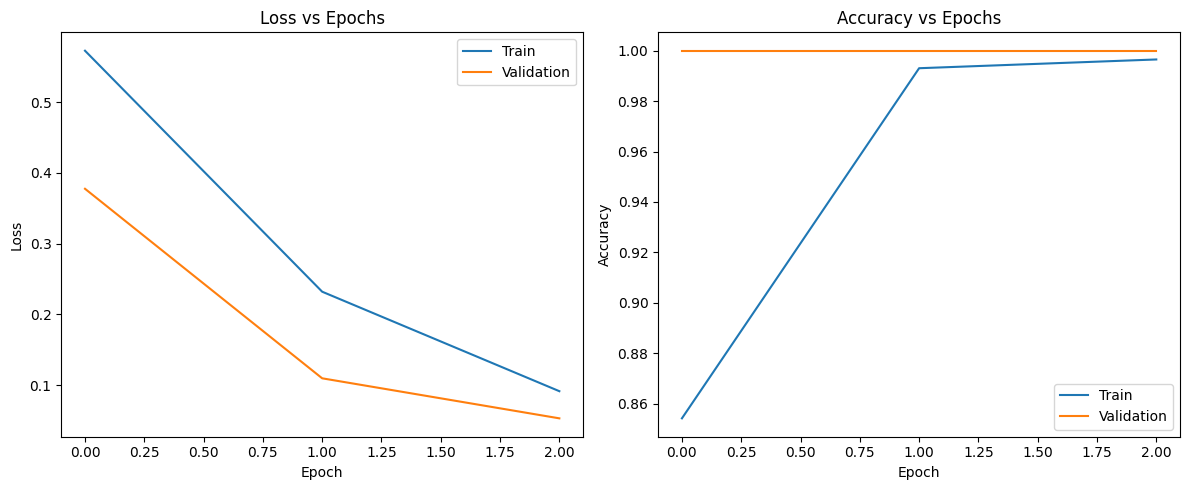

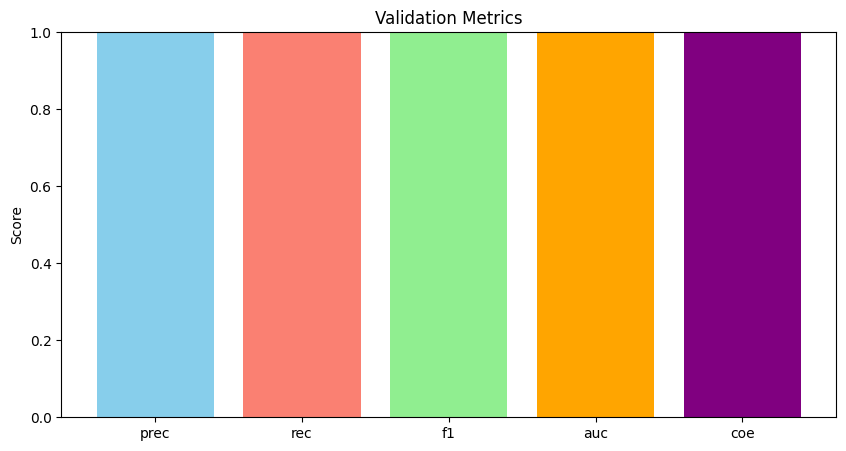


Final Training Metrics:
Loss: 0.0915
Accuracy: 0.9965
Precision: 1.0000
Recall: 0.9931
F1: 0.9965
AUC-ROC: 0.9966
COE: 0.9861

Final Validation Metrics:
Loss: 0.0531
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
AUC-ROC: 1.0000
COE: 1.0000

Test Metrics:
Loss: 0.0513
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
AUC-ROC: 1.0000
COE: 1.0000


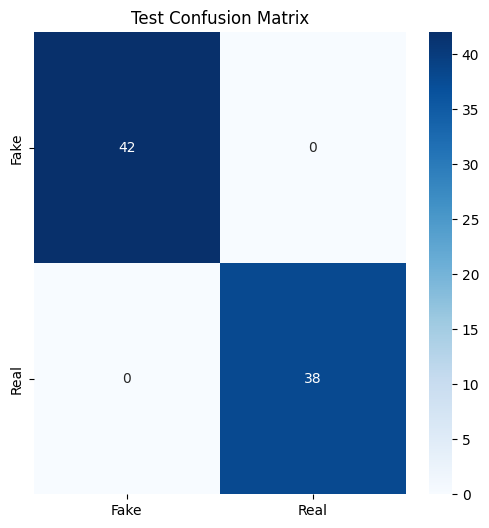

In [9]:
# Enhanced Fake News Detection with DistilBERT - Full Metrics Tracking
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# 1. Data Preparation
def load_data():
    true_df = pd.read_csv('/kaggle/input/fakenews1/True.csv').sample(200)
    fake_df = pd.read_csv('/kaggle/input/fakenews1/Fake.csv').sample(200)
    
    true_df['label'] = 1
    fake_df['label'] = 0
    df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)
    
    # Feature engineering
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.year.fillna(2020)
    df['year_norm'] = (df['date'] - 2000) / 20  # Normalized year
    df['category'] = df['subject'].astype('category').cat.codes
    return df

df = load_data()

# 2. Dataset Class
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=96):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['title'] + " [SEP] " + row['text'][:500]  # Truncated text
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'year': torch.FloatTensor([row['year_norm']]),
            'category': torch.LongTensor([row['category']]),
            'label': torch.LongTensor([row['label']])
        }

# 3. Model Architecture
class FakeNewsDetector(nn.Module):
    def __init__(self, num_categories):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_proj = nn.Linear(768, 64)
        self.year_encoder = nn.Linear(1, 8)
        self.category_embed = nn.Embedding(num_categories, 8)
        self.classifier = nn.Sequential(
            nn.Linear(64 + 8 + 8, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, input_ids, attention_mask, year, category):
        text_features = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        text_features = self.text_proj(text_features)
        year_features = self.year_encoder(year)
        category_features = self.category_embed(category).squeeze(1)
        combined = torch.cat([text_features, year_features, category_features], dim=1)
        return self.classifier(combined)

# 4. Training Framework with Full Metrics
class Trainer:
    def __init__(self, model):
        self.model = model.cuda()
        self.metrics = {
            'train': {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': [], 'coe': []},
            'val': {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': [], 'coe': []}
        }
    
    def coe(self, true, pred):
        """Coefficient of Efficiency (1 - MSE/var)"""
        mse = np.mean((np.array(true) - np.array(pred))**2)
        var = np.var(true)
        return max(0, 1 - mse/var) if var != 0 else 0
    
    def train(self, train_loader, val_loader, epochs=3, lr=5e-5):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss, train_preds, train_labels = 0, [], []
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                inputs = {k: v.cuda() for k,v in batch.items() if k != 'label'}
                labels = batch['label'].cuda().squeeze()
                
                optimizer.zero_grad()
                outputs = self.model(**inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
                train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
            
            # Validation
            val_loss, val_preds, val_labels = self.evaluate(val_loader, criterion)
            
            # Calculate and store metrics
            self.store_metrics('train', train_loss/len(train_loader), train_labels, train_preds)
            self.store_metrics('val', val_loss, val_labels, val_preds)
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1} Summary:")
            print(f"Train Loss: {self.metrics['train']['loss'][-1]:.4f} | Val Loss: {self.metrics['val']['loss'][-1]:.4f}")
            print(f"Train Acc: {self.metrics['train']['acc'][-1]:.4f} | Val Acc: {self.metrics['val']['acc'][-1]:.4f}")
        
        # Final plots and results
        self.plot_metrics()
        self.print_final_metrics()
    
    def evaluate(self, loader, criterion):
        self.model.eval()
        loss, preds, labels = 0, [], []
        with torch.no_grad():
            for batch in loader:
                inputs = {k: v.cuda() for k,v in batch.items() if k != 'label'}
                batch_labels = batch['label'].cuda().squeeze()
                outputs = self.model(**inputs)
                loss += criterion(outputs, batch_labels).item()
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                labels.extend(batch_labels.cpu().numpy())
        return loss/len(loader), preds, labels
    
    def store_metrics(self, phase, loss, true, pred):
        self.metrics[phase]['loss'].append(loss)
        self.metrics[phase]['acc'].append(accuracy_score(true, pred))
        self.metrics[phase]['prec'].append(precision_score(true, pred))
        self.metrics[phase]['rec'].append(recall_score(true, pred))
        self.metrics[phase]['f1'].append(f1_score(true, pred))
        self.metrics[phase]['auc'].append(roc_auc_score(true, pred))
        self.metrics[phase]['coe'].append(self.coe(true, pred))
    
    def plot_metrics(self):
        # Loss curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train']['loss'], label='Train')
        plt.plot(self.metrics['val']['loss'], label='Validation')
        plt.title('Loss vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train']['acc'], label='Train')
        plt.plot(self.metrics['val']['acc'], label='Validation')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Metrics bar plot
        metrics = ['prec', 'rec', 'f1', 'auc', 'coe']
        val_metrics = [self.metrics['val'][m][-1] for m in metrics]
        
        plt.figure(figsize=(10, 5))
        plt.bar(metrics, val_metrics, color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'])
        plt.title('Validation Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.show()
    
    def print_final_metrics(self):
        print("\nFinal Training Metrics:")
        print(f"Loss: {self.metrics['train']['loss'][-1]:.4f}")
        print(f"Accuracy: {self.metrics['train']['acc'][-1]:.4f}")
        print(f"Precision: {self.metrics['train']['prec'][-1]:.4f}")
        print(f"Recall: {self.metrics['train']['rec'][-1]:.4f}")
        print(f"F1: {self.metrics['train']['f1'][-1]:.4f}")
        print(f"AUC-ROC: {self.metrics['train']['auc'][-1]:.4f}")
        print(f"COE: {self.metrics['train']['coe'][-1]:.4f}")
        
        print("\nFinal Validation Metrics:")
        print(f"Loss: {self.metrics['val']['loss'][-1]:.4f}")
        print(f"Accuracy: {self.metrics['val']['acc'][-1]:.4f}")
        print(f"Precision: {self.metrics['val']['prec'][-1]:.4f}")
        print(f"Recall: {self.metrics['val']['rec'][-1]:.4f}")
        print(f"F1: {self.metrics['val']['f1'][-1]:.4f}")
        print(f"AUC-ROC: {self.metrics['val']['auc'][-1]:.4f}")
        print(f"COE: {self.metrics['val']['coe'][-1]:.4f}")

# 5. Training Execution
# Prepare data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(NewsDataset(train_df, tokenizer), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(NewsDataset(val_df, tokenizer), batch_size=BATCH_SIZE)
test_loader = DataLoader(NewsDataset(test_df, tokenizer), batch_size=BATCH_SIZE)

# Initialize and train model
model = FakeNewsDetector(len(df['category'].unique()))
trainer = Trainer(model)
trainer.train(train_loader, val_loader, epochs=3)

# 6. Final Test Evaluation
test_loss, test_preds, test_labels = trainer.evaluate(test_loader, nn.CrossEntropyLoss())
print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"Precision: {precision_score(test_labels, test_preds):.4f}")
print(f"Recall: {recall_score(test_labels, test_preds):.4f}")
print(f"F1: {f1_score(test_labels, test_preds):.4f}")
print(f"AUC-ROC: {roc_auc_score(test_labels, test_preds):.4f}")
print(f"COE: {trainer.coe(test_labels, test_preds):.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title('Test Confusion Matrix')
plt.show()

In [11]:
def print_model_summary(model):
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*60)
    
    # Counting total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Printing layer-wise breakdown
    for name, module in model.named_children():
        num_params = sum(p.numel() for p in module.parameters())
        print(f"{name:<20} {str(type(module)):<30} {num_params:,} parameters")
        
        # Printing submodules for BERT
        if name == 'bert':
            for bert_name, bert_layer in module.named_children():
                bert_params = sum(p.numel() for p in bert_layer.parameters())
                print(f"  {bert_name:<18} {str(type(bert_layer)):<28} {bert_params:,} parameters")
    
    print("="*60)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print("="*60)

print_model_summary(model)


MODEL ARCHITECTURE SUMMARY
bert                 <class 'transformers.models.distilbert.modeling_distilbert.DistilBertModel'> 66,362,880 parameters
  embeddings         <class 'transformers.models.distilbert.modeling_distilbert.Embeddings'> 23,835,648 parameters
  transformer        <class 'transformers.models.distilbert.modeling_distilbert.Transformer'> 42,527,232 parameters
text_proj            <class 'torch.nn.modules.linear.Linear'> 49,216 parameters
year_encoder         <class 'torch.nn.modules.linear.Linear'> 16 parameters
category_embed       <class 'torch.nn.modules.sparse.Embedding'> 64 parameters
classifier           <class 'torch.nn.modules.container.Sequential'> 2,658 parameters
Total parameters: 66,414,834
Trainable parameters: 66,414,834
Non-trainable parameters: 0
